# Kaggle : Titanic competition

## Introduction

This is the work I did for the famous Kaggle competition **Titanic**.

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

The notebook explains my work, the choices I did and the results I got.

## Data

In [1]:
# use of pandas for data processing
import pandas as pd
# file names
training_file = "./data/train.csv"
submission_file = "./data/test.csv"

In [2]:
# creation of a dataframe for each file
training_data = pd.read_csv(training_file)
submission_data = pd.read_csv(submission_file)

In [3]:
print("Training data overview : \n\n",training_data[:10])

Training data overview : 

    PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarth

In [4]:
print("Submission data overview : \n\n",submission_data[:10])

Submission data overview : 

    PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   
5          897       3                    Svensson, Mr. Johan Cervin    male   
6          898       3                          Connolly, Miss. Kate  female   
7          899       2                  Caldwell, Mr. Albert Francis    male   
8          900       3     Abrahim, Mrs. Joseph (Sophie Halaut Easu)  female   
9          901       3                       Davies, Mr. John Samuel    male   

    Age  SibSp  Parch     Ticket     Fare Cabin Embarked  
0  34.5      0      0     3309

### What is inside training data ?

In [5]:
import math

print("Training dataset size : ",training_data.shape)

# data shuffling and reindexing
training_data = training_data.sample(frac=1).reset_index(drop=True)

# list of booleans with true value if a passenger survived and false othherwise
list_survivors = (training_data[:]["Survived"]==1)

# division of training dataset 80% for training and 20% for testing
threshold = 0.8
training_data,test_data = training_data[:int(threshold*training_data.shape[0])],training_data[int(threshold*training_data.shape[0]):].reset_index(drop=True)

# proportion of survival in training dataset
training_survivor_proportion = 0
# list of survived passenger id 
index_survivors = []
for i in range(training_data.shape[0]):
    if list_survivors[i]:
        training_survivor_proportion += 1
        index_survivors.append(i)
training_survivor_proportion /= training_data.shape[0]

print("Survival rate : ",math.floor(10000*training_survivor_proportion)/100, "%")
print("Dissapearence rate : ",math.floor(10000*(1-training_survivor_proportion))/100,"%\n\n")


print("Test dataset shape : ",test_data.shape)
# proportion of survival in training dataset
test_survivor_proportion = 0
for survived in test_data["Survived"]:
    if survived==1:
        test_survivor_proportion += 1
test_survivor_proportion /= test_data.shape[0]

print("Survival rate : ",math.floor(10000*test_survivor_proportion)/100,"%")
print("Dissapearence rate : ",math.floor(10000*(1-test_survivor_proportion))/100,"%")

Training dataset size :  (891, 12)
Survival rate :  37.5 %
Dissapearence rate :  62.5 %


Test dataset shape :  (179, 12)
Survival rate :  41.89 %
Dissapearence rate :  58.1 %


The training dataset consists in 891 passengers, 61% of whom died and 39% survived.
The dataset is **not perfectly balanced**, that is something we should take into account in the next part.

### Rebalancing training data something

The goal here is to achieve 50% of survival and 50% of dissapearence.

In [6]:
# add the required number of survivor in the training dataset in order to reach equality beetwen survival and dissapearence rates. 
training_data = training_data.copy().append(training_data.iloc[index_survivors[0:int(training_data.shape[0]*(1-2*training_survivor_proportion))+1]],ignore_index=True)

print("New training dataset size : ",training_data.shape)

# Computation of survival and dissapearence rates
list_survivors = (training_data[:]["Survived"]==1)
training_survivor_proportion = 0
for i in range(training_data.shape[0]):
    if list_survivors.iloc[i]:
        training_survivor_proportion += 1
training_survivor_proportion /= training_data.shape[0]

print("Survival rate : ",100*training_survivor_proportion)
print("Dissapearence rate : ",100*(1-training_survivor_proportion))



New training dataset size :  (891, 12)
Survival rate :  50.05611672278339
Dissapearence rate :  49.94388327721661


## Analysing people's name

In [7]:
import re
import operator
from collections import Counter 

name_dict = Counter()

for name in training_data["Name"]:
    name = re.compile('[^a-zA-Z]').sub(' ', name).lower()
    name_dict += Counter(name.strip().split(" "))

name_dict_sorted = sorted(name_dict.items(), key=operator.itemgetter(1), reverse=True)

print(name_dict_sorted[:10])

[('', 2017), ('mr', 460), ('miss', 210), ('mrs', 153), ('william', 68), ('master', 47), ('john', 44), ('henry', 38), ('george', 27), ('charles', 26)]


The more occurente title are **mr**, **miss** and **mrs**. It could be interesting to include this as a feature in the input layer.

### Strategy

The goal here is to learn from the training dataset, if a given passenger would survived the titanic shipwreck.

To do so, we have a few informations per passenger : 
- the passenger id (PassengerId)
- whether he survived or not (Survived)
- the ticket class (Pclass)
- his name (Name)
- his sex (Sex)
- his age (Age)
- the number of siblings/spouses aboard the Titanic (SibSp)
- the number of parents/children abroad the Titanic (Parch)
- the ticket number (Ticket)
- the passenger fare (Fare)
- the cabin number (Cabin)
- the port of embarkation (Embarked)

Those information include a number of interesting features (inputs) to predict the output : whether a passenger survive or not.

This is a **classification problem**, given a passenger, we would like to predict 1 if he survived and 0 otherwise. 

Different machine learning can be used in order predict that. 
For this particular one, I will try both **Sequential Neural Network** and **Logistic Regression** and compare the results.

## 1st approach : Sequential Neural Network

### Strucure of the Neural Network

- **the input layor** consists of the features given in the training dataset and explained above
- **two headen layers**
- **the output layer** consists in one neuron, activated by a **sigmoid** function. With a threshold of 0.5, this neuron gives the prediction of the dead of a given passenger.

The NN is trained with keras (tensorflow) and tested on the test dataset.


### The input layer

The input layer is composed of 5 features, the relevant passenger information, i-e the class, the sex, the age, the family information. The other features (id, name, the ticket and cabin numbers, the fare, the embarkation location) seems not so relevant to decide whether a passenger is more lucky to survive than an other one. 

The input layer is a 5-element normalised vector.  

In [8]:
import numpy as np

# used features : Pclass, Sex, Age, SibSp, Parch, Title
features = ["class1","class2","class3","male","female","Age","SibSp","Parch","mr","miss","mrs"]

def data_to_layers(data,features,need_output = True):
    # initilisation of input and output for training time
    input_data = np.zeros((data.shape[0],len(features)))
    if need_output :
        output_data = np.zeros((data.shape[0],1))
    # features max values used for data processing 
    max_age = data["Age"].max()
    max_sibsp = data["SibSp"].max()
    max_parch = data["Parch"].max()
    # data processing 
    # every feature value is moved beetwen 0 and 1
    for i in range(data.shape[0]):
        # 3 different classes 0 for the 1st class, 0.5 for second and 1 for the third one
        input_data[i][0:3][data["Pclass"][i]-1] = 1
        # 0 for male and 1 for female
        input_data[i][3:5][["male","female"].index(data["Sex"][i])] = 1
        # features divided by max value
        input_data[i][5] = data["Age"][i] / max_age 
        input_data[i][6] = data["SibSp"][i] / max_sibsp
        input_data[i][7] = data["Parch"][i] / max_parch
        # title if the person have one
        word_list = re.compile('[^a-zA-Z]').sub(' ', data["Name"][i]).lower().strip().split(" ")
        for j in range(3):
            if ["mr","miss","mrs"][j] in word_list:
                input_data[i][8:11][j] = 1

        # modification of nan value to 0
        if  len(np.where(np.isnan(input_data[i]))) > 0:
            for index in np.where(np.isnan(input_data[i])):
                input_data[i][index] = 0
        if need_output :
            # output data set
            output_data[i] = data["Survived"][i]
        
        # Normalisation of inputs
        input_data[i] -= np.mean(input_data[i])
        if np.std(input_data[i]) != 0:
            input_data[i] /= np.std(input_data[i])
    if need_output:
        return input_data,output_data
    else :
        return input_data,[]

In [9]:
# input data processing 
input_training_data,output_training_data = data_to_layers(training_data,features)

print("Size of both sets : \n",input_training_data.shape, output_training_data.shape)

print("Input at training time : \n",input_training_data[:10])
print("Output at training time : \n",output_training_data[:10])

Size of both sets : 
 (891, 11) (891, 1)
Input at training time : 
 [[ 1.63299316 -0.61237244 -0.61237244  1.63299316 -0.61237244 -0.61237244
  -0.61237244 -0.61237244  1.63299316 -0.61237244 -0.61237244]
 [-0.61237244 -0.61237244  1.63299316 -0.61237244  1.63299316 -0.61237244
  -0.61237244 -0.61237244 -0.61237244 -0.61237244  1.63299316]
 [-0.69663283  1.59081825 -0.69663283 -0.69663283  1.59081825  0.10397505
  -0.69663283 -0.69663283 -0.69663283  1.59081825 -0.69663283]
 [-0.76304999  1.53655272 -0.76304999  1.53655272 -0.76304999  0.44424143
  -0.47559965 -0.76304999  1.53655272 -0.76304999 -0.76304999]
 [ 1.47760326 -0.77984617 -0.77984617 -0.77984617  1.47760326  0.7439322
  -0.49766499 -0.77984617 -0.77984617  1.47760326 -0.77984617]
 [-0.87145626 -0.87145626  1.34710163 -0.87145626  1.34710163  0.21009071
  -0.87145626  0.97734198 -0.87145626 -0.87145626  1.34710163]
 [ 1.57899711 -0.74073153 -0.74073153 -0.74073153  1.57899711  0.15816332
  -0.45076545 -0.74073153 -0.74073153

In [10]:
# test data processing
input_test_data,output_test_data = data_to_layers(test_data,features)

print("Size of both sets : \n",input_test_data.shape, output_test_data.shape)

print("Input at test time : \n",input_test_data[:10])
print("Output at test time : \n",output_test_data[:10])

Size of both sets : 
 (179, 11) (179, 1)
Input at test time : 
 [[ 1.60252309 -0.6861632  -0.6861632  -0.6861632   1.60252309 -0.00442686
  -0.6861632  -0.6861632  -0.6861632   1.60252309 -0.6861632 ]
 [-0.75462829 -0.75462829  1.58062406  1.58062406 -0.75462829  0.07347538
  -0.28757782 -0.75462829  1.58062406 -0.75462829 -0.75462829]
 [-0.73436626 -0.73436626  1.51218615  1.51218615 -0.73436626  0.60400539
  -0.73436626 -0.73436626  1.51218615 -0.73436626 -0.73436626]
 [ 1.53649412 -0.80539108 -0.80539108  1.53649412 -0.80539108  0.09150112
  -0.80539108  0.131363    1.53649412 -0.80539108 -0.80539108]
 [ 1.57061541 -0.71030641 -0.71030641  1.57061541 -0.71030641  0.26029862
  -0.71030641 -0.71030641  1.57061541 -0.71030641 -0.71030641]
 [-0.87182534  1.38409909 -0.87182534  1.38409909 -0.87182534  1.04811034
  -0.42064045 -0.42064045  1.38409909 -0.87182534 -0.87182534]
 [-0.67063351 -0.67063351  1.6154161   1.6154161  -0.67063351 -0.15181374
  -0.67063351 -0.67063351  1.6154161  -0

### Neural network training

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

# definition of our keras model (using sequential neural network)
model = Sequential()
# add a hidden layer with 256 nodes with activation relu
model.add(Dense(128, input_dim=len(features), activation='relu'))
# add a little dropout 
model.add(Dropout(0.3))
# add an other hidden layer with 128 nodes with activation relu
model.add(Dense(64, activation='relu'))
# add a little dropout
model.add(Dropout(0.3))
# add the output layer with activation sigmoid
model.add(Dense(1, activation='sigmoid'))



Using TensorFlow backend.


In [12]:
# compiling the model with binary_crossentropy loss, adam optimizer and accuracy metrics 
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# displaying the model
print(model.summary())
# training the model with training data, 10 epochs and batch of size 32
print(model.fit(input_training_data, output_training_data,epochs=10,batch_size=32,verbose=1,shuffle=True))
# evaluation of model accuracy
_ , acc = model.evaluate(input_test_data, output_test_data, batch_size=32)
print('test accuracy: ', acc)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1536      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
891/891 [==============================] - 1s 695us/step - loss: 0.5584 - accuracy: 0.7374
Epoch 2/10


The neural netork has been trained with an **accuracy** of **98%**.
Let's build some indicator, **confusion matrix and AUC-ROC** to check this value.

In [13]:
def predict(vec_sentence):
    """
    This function takes a sentence's vector and returns the output of the neural network (rounded to 0 or 1).
    """
    return np.round(model.predict(vec_sentence))

In [14]:
from sklearn.metrics import confusion_matrix
# results of the predictions with trained neural network
pred = [round(elt[0]) for elt in predict(input_test_data)]
# display part of the outcomes
print("Real outcomes : \n",output_test_data[0:10].tolist())
print("Predicted outcomes : \n",pred[0:10])
print("Confusion matrix : \n",confusion_matrix(output_test_data, pred))


Real outcomes : 
 [[1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0]]
Predicted outcomes : 
 [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Confusion matrix : 
 [[85 19]
 [20 55]]


AUC-ROC score :  0.7753205128205128


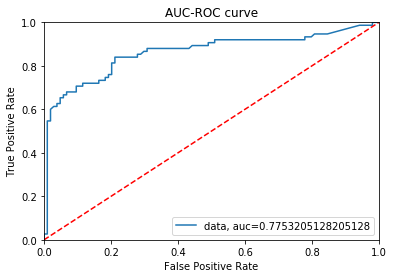

In [15]:
from sklearn.metrics import roc_auc_score

# computation of the AUC-ROC score
auc = roc_auc_score(output_test_data, pred)
print("AUC-ROC score : ",auc)

import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# calculate the false positive rate fpr and true positive tpr for all thresholds of the classification
probs = model.predict(input_test_data)
fpr, tpr, threshold = metrics.roc_curve(output_test_data, probs)

plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.title('AUC-ROC curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()




## Conclusion du RNN

The results I got are very satisfaying. The accuracy is very high and the network is able to learn from data and predict wheter a Titanic passenger will die or not.

In [16]:
# creation of submission file
submission_content = "PassengerId,Survived\n"

# submission data processing 
input_submission_data,_ = data_to_layers(submission_data,features,False)

print("Size of submission set : \n",input_submission_data.shape)

print("Input at submission time : \n",input_submission_data[:10])

pred_submission = [round(elt[0]) for elt in predict(input_submission_data)]

print("Output at submission time : \n", pred_submission[:10])

for i in range(len(submission_data)):
    submission_content = submission_content + (str(submission_data["PassengerId"][i]) + "," + str(int(pred_submission[i])) + "\n")

print(submission_content)


Size of submission set : 
 (418, 11)
Input at submission time : 
 [[-0.71497889 -0.71497889  1.56205865  1.56205865 -0.71497889  0.31867631
  -0.71497889 -0.71497889  1.56205865 -0.71497889 -0.71497889]
 [-0.7744271  -0.7744271   1.50121808 -0.7744271   1.50121808  0.63287979
  -0.48997145 -0.7744271  -0.7744271  -0.7744271   1.50121808]
 [-0.75181019  1.41547711 -0.75181019  1.41547711 -0.75181019  1.01623998
  -0.75181019 -0.75181019  1.41547711 -0.75181019 -0.75181019]
 [-0.69764374 -0.69764374  1.58953338  1.58953338 -0.69764374  0.11490603
  -0.69764374 -0.69764374  1.58953338 -0.69764374 -0.69764374]
 [-0.75510294 -0.75510294  1.6008558  -0.75510294  1.6008558  -0.07311488
  -0.4606081  -0.49332974 -0.75510294 -0.75510294  1.6008558 ]
 [-0.66060082 -0.66060082  1.62147474  1.62147474 -0.66060082 -0.24021848
  -0.66060082 -0.66060082  1.62147474 -0.66060082 -0.66060082]
 [-0.70494961 -0.70494961  1.57930571 -0.70494961  1.57930571  0.19673012
  -0.70494961 -0.70494961 -0.70494961 

## Logistic Regression


C:\Users\Julienv\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
Logistic regression training accuracy : 
 0.7890011223344556
Predicted outcomes : 
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
True outcomes : 
 [[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]
Accuracy on test set : 
 0.7988826815642458
Logistic confusion matrix : 
 [[86 18]
 [18 57]]


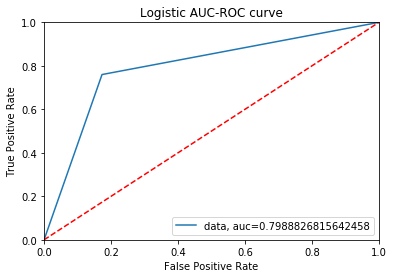

In [17]:
from sklearn.linear_model import LogisticRegression


# Training of our logistic regression
clf = LogisticRegression(random_state=0, solver='lbfgs',verbose=4,max_iter=150000, multi_class='ovr').fit(input_training_data, output_training_data)
print("Logistic regression training accuracy : \n",clf.score(input_training_data, output_training_data))

# test of the regression
logistic_prediction = clf.predict(input_test_data)
print("Predicted outcomes : \n",logistic_prediction[:10])
print("True outcomes : \n",output_test_data[:10])

# calculation of the accuracy on test set
nb_right = 0
for i in range(len(logistic_prediction)):
    if logistic_prediction[i] == output_test_data[i]:
        nb_right += 1

print("Accuracy on test set : \n",nb_right/len(logistic_prediction))

logistic_confusion_matrix = confusion_matrix(output_test_data,logistic_prediction)
print("Logistic confusion matrix : \n",logistic_confusion_matrix)


fpr, tpr, threshold = metrics.roc_curve(output_test_data, logistic_prediction)

plt.plot(fpr,tpr,label="data, auc="+str(nb_right/len(logistic_prediction)))
plt.title('Logistic AUC-ROC curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [18]:
def predict_logistic(vec_sentence):
    """
    This function takes a sentence's vector and returns the output of the neural network (rounded to 0 or 1).
    """
    if len(vec_sentence) == 1:
        vec_sentence = [vec_sentence]
    return np.round(clf.predict(vec_sentence))

In [19]:
# creation of submission file
submission_content_logistic = "PassengerId,Survived\n"

pred_logistic_submission = [round(elt) for elt in predict_logistic(input_submission_data)]

print("Output at submission time : \n", pred_logistic_submission[:10])

for i in range(len(submission_data)):
    submission_content_logistic = submission_content_logistic + (str(submission_data["PassengerId"][i]) + "," + str(int(pred_logistic_submission[i])) + "\n")

print(submission_content_logistic)

Output at submission time : 
 [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1
901,0
902,0
903,0
904,1
905,0
906,1
907,1
908,0
909,0
910,1
911,1
912,0
913,1
914,1
915,1
916,1
917,0
918,1
919,0
920,0
921,0
922,0
923,0
924,1
925,1
926,0
927,0
928,1
929,1
930,0
931,0
932,0
933,1
934,0
935,1
936,1
937,0
938,0
939,0
940,1
941,1
942,0
943,0
944,1
945,1
946,0
947,0
948,0
949,0
950,0
951,1
952,0
953,0
954,0
955,1
956,1
957,1
958,1
959,0
960,0
961,1
962,1
963,0
964,1
965,0
966,1
967,0
968,0
969,1
970,0
971,1
972,1
973,0
974,0
975,0
976,0
977,0
978,1
979,1
980,1
981,1
982,1
983,0
984,1
985,0
986,0
987,0
988,1
989,0
990,1
991,0
992,1
993,0
994,0
995,0
996,1
997,0
998,0
999,0
1000,0
1001,0
1002,0
1003,1
1004,1
1005,1
1006,1
1007,0
1008,0
1009,1
1010,0
1011,1
1012,1
1013,0
1014,1
1015,0
1016,0
1017,1
1018,0
1019,1
1020,0
1021,0
1022,0
1023,1
1024,1
1025,0
1026,0
1027,0
1028,0
1029,0
1030,1
1031,0
1032,0
1033,1
1034,0
1035,

### Comparaison beetwen NN and logistic regression appraoch



In [20]:
number_of_differences = 0
for i in range(len(pred_logistic_submission)):
    if pred_logistic_submission[i] != pred_submission[i]:
        number_of_differences += 1
print("Number of differences beetwen both techniques : ",number_of_differences)
print("Proportion of differences beetwen both techniques : ",np.floor(10000*number_of_differences/len(pred_logistic_submission))/100, "%")

Number of differences beetwen both techniques :  2
Proportion of differences beetwen both techniques :  0.47 %


## Conclusion 

Both methods, sequential neural network and logistic regression, gave impressivly high accuracy : 
- 77.5 % of accuracy for sequential neural network
- 80 % of accuracu for logistic regression.

The approach above could be optimiserd or some other machine learning technics could be implemented in order to achieve a better score.